In [1]:
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
exp_pat = "B0_244"
Image_shape = 224
BATCH_SIZE = 64


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Felix\weather_data_set_ready_to_train\train",
shuffle=True,
batch_size=BATCH_SIZE,
image_size=(Image_shape,Image_shape))
val_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Felix\weather_data_set_ready_to_train\val",
shuffle=False,
batch_size=BATCH_SIZE,
image_size=(Image_shape,Image_shape))


y_train = np.concatenate(list(train_ds.map(lambda x,y: y)))
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train),  y=y_train)
class_weights = {i:o for i,o in enumerate(class_weights)}

Found 16820 files belonging to 5 classes.
Found 1411 files belonging to 5 classes.


In [3]:
inputs = tf.keras.Input((Image_shape,Image_shape ,3))

img_augmentation = tf.keras.models.Sequential(
[
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomContrast(factor=0.2)

],
name="img_augmentation",
)

x = img_augmentation(inputs)


base = tf.keras.applications.EfficientNetV2B0(
include_top=False,
weights='imagenet',
pooling="avg"
)

base.trainable = False
x = base(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.2, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)
model = tf.keras.Model(inputs, outputs)

def unfreeze_model(model,n_layers = 20):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization) and not isinstance(layer, tf.keras.layers.LayerNormalization):
            layer.trainable = True
    return model


In [4]:
model.compile(tf.optimizers.Adam(1e-3),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

hist1 = model.fit(train_ds,epochs = 2,validation_data=val_ds,initial_epoch=0,class_weight=class_weights)
model = unfreeze_model(model)
model.compile(tf.optimizers.Adam(1e-4),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    restore_best_weights=True)


hist2 = model.fit(train_ds,epochs = 12,validation_data=val_ds,initial_epoch=2, callbacks= [early_stop],class_weight=class_weights)


Epoch 1/2
263/263 [==============================] - 25s 65ms/step - loss: 0.6651 - accuracy: 0.7857 - val_loss: 0.5563 - val_accuracy: 0.8625
Epoch 2/2
263/263 [==============================] - 16s 60ms/step - loss: 0.4318 - accuracy: 0.8701 - val_loss: 0.4801 - val_accuracy: 0.8724
Epoch 3/12
263/263 [==============================] - 45s 146ms/step - loss: 0.3556 - accuracy: 0.8971 - val_loss: 0.4994 - val_accuracy: 0.8653
Epoch 4/12
263/263 [==============================] - 37s 140ms/step - loss: 0.2139 - accuracy: 0.9478 - val_loss: 0.3680 - val_accuracy: 0.9178
Epoch 5/12
263/263 [==============================] - 36s 137ms/step - loss: 0.1763 - accuracy: 0.9618 - val_loss: 0.2965 - val_accuracy: 0.9369
Epoch 6/12
263/263 [==============================] - 37s 139ms/step - loss: 0.1427 - accuracy: 0.9702 - val_loss: 0.3405 - val_accuracy: 0.9192
Epoch 7/12
263/263 [==============================] - 37s 139ms/step - loss: 0.1226 - accuracy: 0.9765 - val_loss: 0.3551 - val_accura

In [13]:
os.makedirs(exp_pat,exist_ok=True)
model.save_weights(os.path.join(exp_pat,"warm.cpkt"))

In [9]:
labels = np.concatenate(list(val_ds.map(lambda x,y: y)))
pred = model.predict(val_ds,verbose=1)

confusion_mtx = tf.math.confusion_matrix(labels,np.argmax(pred,axis=-1))


23/23 [==============================] - 1s 56ms/step


In [10]:
np.unique(labels,return_counts=True,)

(array([0, 1, 2, 3, 4]), array([300, 300, 111, 400, 300], dtype=int64))

In [11]:
p = np.argmax(pred,axis=1)
for i in range(5):

    mask = labels == i
    acc = (labels[mask]==p[mask]).mean()
    print(val_ds.class_names[i],acc)

Clear 0.8566666666666667
Cloudy 0.9933333333333333
Foggy 0.8378378378378378
Rainy 0.98
Snowy 0.94


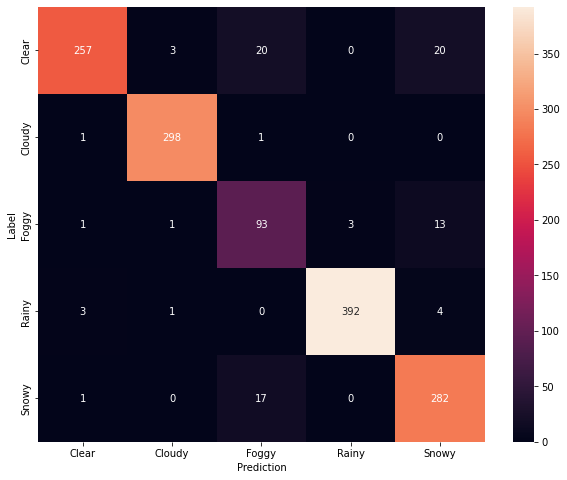

In [12]:

plt.figure(figsize=(10, 8))

names =val_ds.class_names


sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
#plt.title(f"Val Confusion Matrix - ACC {acc*100:.2f}%",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')

plt.show()

In [ ]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
hist2 = model.fit(train_ds,epochs = 16,validation_data=val_ds,initial_epoch=13, callbacks= [early_stop])


Epoch 14/16
193/193 [==============================] - 32s 143ms/step - loss: 0.1462 - accuracy: 0.9716 - val_loss: 0.9352 - val_accuracy: 0.7434
Epoch 15/16
193/193 [==============================] - 28s 142ms/step - loss: 0.1243 - accuracy: 0.9786 - val_loss: 1.3113 - val_accuracy: 0.6924
Epoch 16/16
193/193 [==============================] - 28s 143ms/step - loss: 0.1098 - accuracy: 0.9851 - val_loss: 1.2677 - val_accuracy: 0.7023
